# Feature Engineering for Telecom ML Platform

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
sns.set(style="whitegrid")
PROCESSED_PATH = "../data/processed/"

# Load processed datasets

In [6]:
traffic = pd.read_csv(PROCESSED_PATH + "traffic_volume.csv")
users = pd.read_csv(PROCESSED_PATH + "user_churn_dataset.csv")
plans = pd.read_csv(PROCESSED_PATH + "user_plan_history.csv")
profiles = pd.read_csv(PROCESSED_PATH + "user_profiles.csv")
towers = pd.read_csv(PROCESSED_PATH + "tower_locations.csv")
graph_edges = pd.read_csv(PROCESSED_PATH + "telecom_graph_edges.csv")
logs = pd.read_csv(PROCESSED_PATH + "network_behaviors.csv")

# ─────────────────────────────────────────────
# 🧠 Feature Engineering Examples
# ─────────────────────────────────────────────

### Time-based features from traffic data

In [7]:
traffic["hour"] = pd.to_datetime(traffic["hour"])
traffic["hour_of_day"] = traffic["hour"].dt.hour
traffic["day_of_week"] = traffic["hour"].dt.dayofweek

### Aggregate user features

In [8]:
user_features = plans.groupby("user_id").agg({
    "minutes_used": "mean",
    "data_used_gb": "mean",
    "satisfaction_score": "mean"
}).reset_index()
user_features.columns = ["user_id", "avg_minutes", "avg_data", "avg_satisfaction"]

### Merge with user churn dataset

In [18]:
users

,user_id,churned,avg_minutes,avg_data_gb,avg_satisfaction
0,U0024,1,302.833333,5.711667,3.650000
1,U0343,0,291.500000,14.145000,3.400000
2,U0065,0,300.000000,4.640000,3.433333
3,U0303,0,301.000000,8.131667,3.716667
4,U0317,0,298.000000,7.875000,2.666667
...,...,...,...,...,...
495,U0321,0,296.500000,5.706667,3.716667
496,U0480,0,296.333333,5.035000,3.566667
497,U0371,0,303.500000,4.936667,3.050000
498,U0190,0,295.500000,14.190000,3.300000


In [32]:
user_merged = users.merge(profiles, on="user_id", how="left")
cols_to_use = user_features.columns.difference(user_merged.columns).tolist()
cols_to_use.append("user_id")
user_merged = user_merged.merge(user_features[cols_to_use], on="user_id", how="left")

# Save user feature matrix
user_merged.to_csv(PROCESSED_PATH + "user_feature_matrix.csv", index=False)
print("✅ Saved: user_feature_matrix.csv")

✅ Saved: user_feature_matrix.csv


### Tower-level features

In [12]:
tower_agg = traffic.groupby("tower_id").agg({
    "total_calls": "mean",
    "total_data_used_mb": "mean"
}).reset_index()
tower_agg.columns = ["tower_id", "avg_calls", "avg_data_mb"]

# Merge with tower geo info
tower_features = tower_agg.merge(towers, on="tower_id", how="left")
tower_features.to_csv(PROCESSED_PATH + "tower_feature_matrix.csv", index=False)
print("✅ Saved: tower_feature_matrix.csv")

✅ Saved: tower_feature_matrix.csv


# ─────────────────────────────────────────────
# 📊 Quick EDA Plots
# ─────────────────────────────────────────────

### Average User Data Usage Distribution

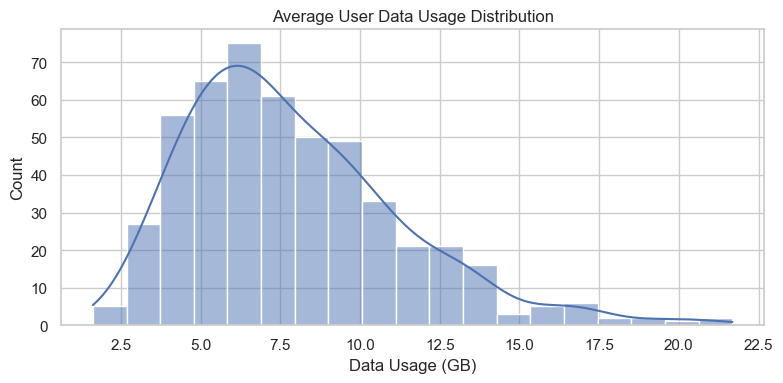

In [33]:
plt.figure(figsize=(8, 4))
sns.histplot(user_merged["avg_data"], kde=True)
plt.title("Average User Data Usage Distribution")
plt.xlabel("Data Usage (GB)")
plt.tight_layout()
plt.show()

### Churn vs. Average Call Minutes

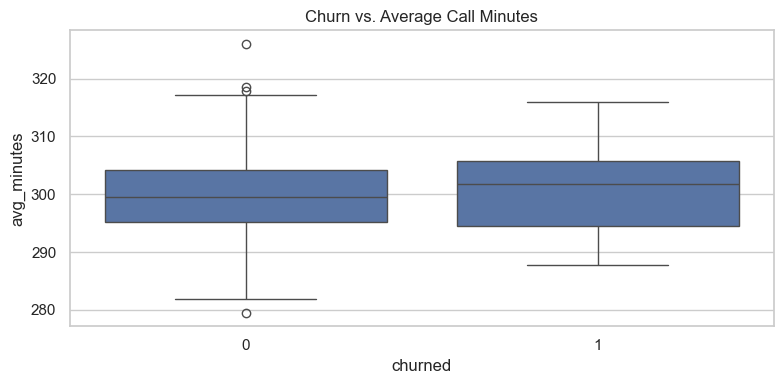

In [34]:
plt.figure(figsize=(8, 4))
sns.boxplot(x="churned", y="avg_minutes", data=user_merged)
plt.title("Churn vs. Average Call Minutes")
plt.tight_layout()
plt.show()

### User Churn Analysis

Text(0.5, 1.0, 'Churn Distribution')

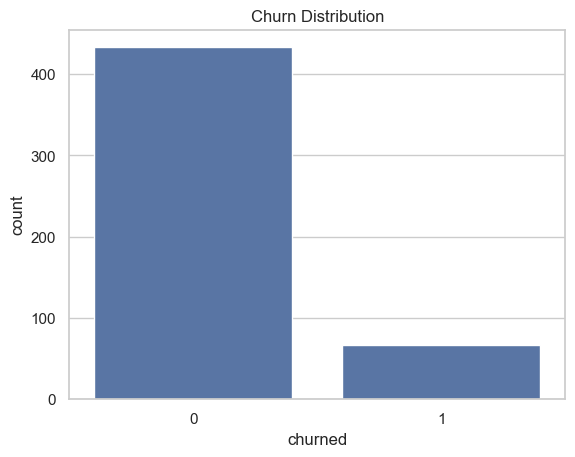

In [37]:
user_feature_matrix = pd.read_csv(PROCESSED_PATH + "user_feature_matrix.csv")
sns.countplot(x='churned', data=user_feature_matrix)
plt.title('Churn Distribution')